# 04 - Kanton Zürich Wärmenutzungsatlas - Erdwärmezonen
### Author: Daniel Herrera-Russert
#### February 03, 2025

In [1]:
# !pip install geopandas owslib requests pyproj fiona

In [2]:
import pandas as pd
import numpy as np
import os

from owslib.wfs import WebFeatureService
import geopandas as gpd
import requests
from io import BytesIO
import fiona

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyproj import Transformer # for converting coordinates

# Set the default renderer for JupyterLab
pio.renderers.default = 'iframe'

## 1. Loading the dataset

As part of the data obtained from the [Wärmenutzungsatlas](https://maps.zh.ch/s/yfueq6wo) of Kanton Zürich, we now proceed with the extraction of the geographical dataset containing the data for ground heat usage. See the [metadata](https://www.geolion.zh.ch/geodatensatz/show?gdsid=316).


The data is retrieved from the GIS portal via WFS service, in order to obtain the separate layers preserving the geographic data qualities. Alternatively, it could be downloaded manually directly from the GIS download section in a variety of formats for different purposes.

### 1.1. Water protection zones

Following is the extraction and exploration of the dataset,corresponding to the layer containing the water protection zones.

In [3]:
# Define the WFS endpoint
WFS_URL = "https://maps.zh.ch/wfs/AwelGSWaermewwwZHWFS"

# Connect to the WFS service
wfs = WebFeatureService(WFS_URL, version="2.0.0")

# List available layers
print("Available layers:")
for layer in list(wfs.contents):
    print(layer)

Available layers:
ms:waermenutzung-zone-a
ms:waermenutzung-zone-b
ms:waermenutzung-zone-c
ms:waermenutzung-zone-d
ms:waermenutzung-zone-e
ms:waermenutzung-zone-f
ms:erdwaermesonden-auflagen
ms:tunnels-und-stollen
ms:erdwaermesonden
ms:sonden
ms:sammelschacht
ms:grundwasserpiezometer
ms:erdregister
ms:quellfassung-waermenutzung
ms:grundwasserfassung-waermenutzung
ms:quellfassung-ohne-waermenutzung
ms:grundwasserfassung-ohne-waermenutzung


In [4]:
# Define the list of layers to download
layers = [
    "ms:waermenutzung-zone-a",
    "ms:waermenutzung-zone-b",
    "ms:waermenutzung-zone-c",
    "ms:waermenutzung-zone-d",
    "ms:waermenutzung-zone-e",
    "ms:waermenutzung-zone-f",
]

# Define expected CRS (EPSG:2056 - LV95)
expected_crs = "EPSG:2056"

# Define output file
output_geojson = "data/raw/zh_waermenutzung_zonen.geojson"

# Create an empty list to store GeoDataFrames
gdfs = []

# Loop through layers and process each one
for layer in layers:
    print(f"Downloading {layer}...")
    
    # Request data in GML format
    response = wfs.getfeature(typename=layer, outputFormat="GML2")
    
    # Read the response as a GeoDataFrame
    gdf = gpd.read_file(BytesIO(response.read()))
    
    # Check and set CRS if missing
    if gdf.crs is None:
        gdf.set_crs(expected_crs, inplace=True)
    
    # Add a new column for the zone classification based on the layer name
    gdf["ZONEN"] = layer.replace("ms:waermenutzung-zone-", "").upper()
    
    # Append the processed GeoDataFrame to the list
    gdfs.append(gdf)

# Concatenate all layers into a single GeoDataFrame
merged_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# Save the combined dataset as a GeoJSON file
merged_gdf.to_file(output_geojson, driver="GeoJSON")

print(f"All layers saved into '{output_geojson}' with CRS {expected_crs}")

All layers saved into 'data/raw/zh_waermenutzung_zonen.geojson' with CRS EPSG:2056


---

### 1.2. Restrictions (Auflagen)

In [5]:
# Define the restriction layer
restrictions_layer = "ms:erdwaermesonden-auflagen"

# Define output file
output_restrictions_geojson = "data/raw/zh_erdwaermesonden_auflagen.geojson"

print(f"Downloading {restrictions_layer}...")
response = wfs.getfeature(typename=restrictions_layer, outputFormat="GML2")
restrictions_gdf = gpd.read_file(BytesIO(response.read()))

# Check and set CRS if missing
if restrictions_gdf.crs is None:
    restrictions_gdf.set_crs(expected_crs, inplace=True)

# Save the dataset
restrictions_gdf.to_file(output_restrictions_geojson, driver="GeoJSON")

print(f"Restrictions saved as '{output_restrictions_geojson}' with CRS {expected_crs}")

Restrictions saved as 'data/raw/zh_erdwaermesonden_auflagen.geojson' with CRS EPSG:2056


In [7]:
# Load the datasets
zh_waermenutzung_gdf = gpd.read_file("data/raw/zh_waermenutzung_zonen.geojson")
zh_restrictions_gdf = gpd.read_file("data/raw/zh_erdwaermesonden_auflagen.geojson")

# Inspect the first few rows of each dataset
print("Thermal Zones:")
zh_waermenutzung_gdf.head()

Thermal Zones:


,gml_id,ZONEN,geometry
0,waermenutzung-zone-a.1,A,"MULTIPOLYGON (((2685829.327 1249646.519, 26858..."
1,waermenutzung-zone-a.2,A,"MULTIPOLYGON (((2685737.917 1250003.611, 26857..."
2,waermenutzung-zone-a.3,A,"POLYGON ((2685732.254 1250011.309, 2685731.347..."
3,waermenutzung-zone-a.4,A,"POLYGON ((2685751.834 1249872.674, 2685797.339..."
4,waermenutzung-zone-a.5,A,"POLYGON ((2685853.92 1249946.547, 2685846.906 ..."


In [8]:
print("\nRestrictions (Auflagen):")
zh_restrictions_gdf.head()


Restrictions (Auflagen):


,gml_id,zonen,geometry
0,erdwaermesonden-auflagen.107,Verbot,"POLYGON ((2678786.488 1249290.376, 2678785.911..."
1,erdwaermesonden-auflagen.108,Verbot,"POLYGON ((2679379.648 1248504.431, 2679379.044..."
2,erdwaermesonden-auflagen.109,Auflagen,"POLYGON ((2682120.057 1243256.662, 2682110.162..."
3,erdwaermesonden-auflagen.110,Auflagen,"POLYGON ((2699212.881 1268866.187, 2699212.924..."
4,erdwaermesonden-auflagen.111,Auflagen,"MULTIPOLYGON (((2679461.435 1247400.626, 26794..."


In [9]:
# Check unique zone classifications
print("\nUnique ZONEN values in Thermal Zones:", zh_waermenutzung_gdf["ZONEN"].unique())
print("\nUnique ZONEN values in Restrictions:", zh_restrictions_gdf["zonen"].unique())


Unique ZONEN values in Thermal Zones: ['A' 'B' 'C' 'D' 'E' 'F']

Unique ZONEN values in Restrictions: ['Verbot' 'Auflagen']


---

## 2. Structure of the Datasets

### **Thermal Usage Zones**
The `ZONEN` attribute categorizes areas based on **groundwater conditions** and their suitability for geothermal energy extraction:

- **B**: Gravel-based groundwater reservoirs, suitable for drinking water extraction.
- **B_Sperr**: Zone B with a restriction on geothermal probes.
- **C**: Gravel-based groundwater reservoirs, unsuitable for drinking water extraction (high-yield aquifer).
- **C_Sperr**: Zone C with a restriction on geothermal probes.
- **D**: Gravel-based groundwater reservoirs, unsuitable for drinking water extraction (low-yield aquifer).
- **D_Sperr**: Zone D with a restriction on geothermal probes.
- **E**: Spring water areas, suitable for drinking water extraction.
- **E_Sperr**: Zone E with a restriction on geothermal probes.
- **F**: Areas outside of usable groundwater reservoirs.
- **F_Sperr**: Zone F with a restriction on geothermal probes.
- **G**: Protection perimeter around drinking water intakes in the lower groundwater level.

This classification helps in **decision-making for geothermal energy projects**, ensuring compliance with **groundwater protection regulations** and identifying suitable locations for **geothermal probe installations**.

### **Geothermal Probe Restrictions (Erdwärmesonden Auflagen)**
The `zonen` attribute in this dataset categorizes areas based on **usage restrictions** for the construction of geothermal probes:

- **Auflagen**: Areas where geothermal probes are permitted but subject to specific conditions, detailed in the `BEMERKUNG` field.
- **Verbot**: Areas where geothermal probes are strictly prohibited, with explanations provided in the `BEMERKUNG` field.

Additional attributes:
- **`BEMERKUNG`**: Contains justifications for the classification as either **Auflagen** or **Verbot**.
- **`INFO_TXT`**: Provides further details on the nature of usage restrictions.
- **`OBJECTID`**: Unique identifier for each restricted area.
- **`SHAPE`**: Geometric representation of the restricted zones.

This classification is essential for ensuring **compliance with groundwater protection regulations** and guiding the **feasibility assessment of geothermal projects**.


---

## 3. Visualizations

This table from the legend of the [Wärmenutzungsatlas](https://maps.zh.ch/s/yfueq6wo) outlines the **permissibility of different geothermal energy systems** based on **groundwater conditions** and **water protection zones**. The classification determines whether **geothermal probes (Erdwärmesonden), energy piles, and groundwater-based heating systems** are allowed or restricted.

### Key Insights:
- **Zone A** (red) is a **strict protection area** where **all geothermal utilization is prohibited**.
- **Zones B-F** allow varying levels of geothermal use, with some restrictions.
- Areas marked **"S" (Schutzzone)** are the most restrictive, while **"Au" (outside protected zones)** are more flexible.
- **Erdwärmesonden (geothermal probes)** are **only permitted in Zones C, D, E, and F**.

### Geothermal Usage Permissions Table:

| **Groundwater Category**                                     | **Protection Zone** | **Zone** | **Geothermal Probes** | **Thermoactive Elements** | **Energy Registers (Fluid-Based)** | **Energy Registers (Air-Based)** | **Groundwater Heating** |
|-------------------------------------------------------------|--------------------|---------|---------------------|---------------------------|----------------------------------|----------------------------------|-------------------------|
| Gravel groundwater, suitable for drinking water extraction | S                  | A       | **Not Allowed (-)**  | **Not Allowed (-a)**      | **Not Allowed (-a)**            | **Not Allowed (-a)**            | **Not Allowed (-)**      |
| Gravel groundwater, suitable for drinking water extraction | Au                 | B       | **Not Allowed (-)**  | **Allowed (+b)**          | **Allowed (+b)**                | **Allowed (+d)**                | **Allowed (+e)**        |
| Gravel groundwater, unsuitable for drinking water extraction (high-yield) | Au | C | **Allowed (+c)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+f)** |
| Gravel groundwater, unsuitable for drinking water extraction (low-yield) | i.d.R. Au | D | **Allowed (+c)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+f)** |
| Spring water areas, suitable for drinking water extraction | Au | E | **Allowed (+c)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+e)** |
| Areas outside of usable groundwater reserves | i.d.R. üb | F | **Allowed (+)** | **Allowed (+)** | **Allowed (+)** | **Allowed (+)** | **Allowed (+g)** |

### Legend:
- **"-"**: Not allowed
- **"+(letter)"**: Allowed with conditions based on regulations
- **S (Schutzzone)**: Strict water protection area
- **Au (Ausserhalb Schutzzone)**: Outside protection zones
- **i.d.R. Au**: Generally outside protection zones
- **i.d.R. üb**: Generally outside usable reserves

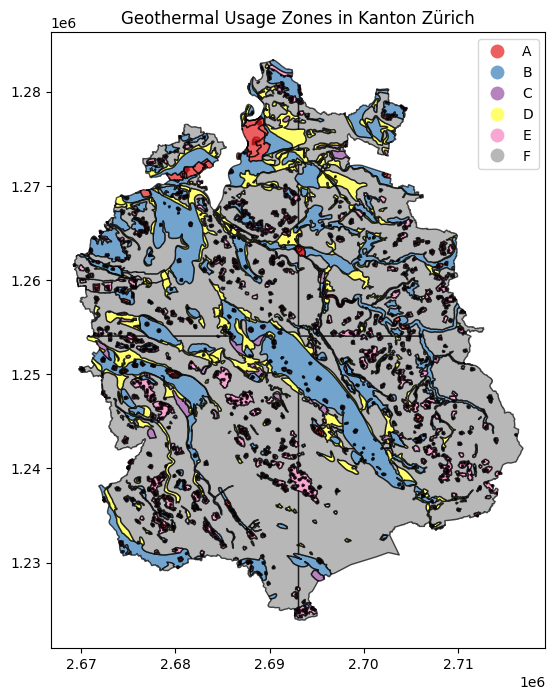

In [10]:
# Plot the dataset
fig, ax = plt.subplots(figsize=(10, 8))
zh_waermenutzung_gdf.plot(ax=ax, column="ZONEN", cmap="Set1", legend=True, edgecolor="black", alpha=0.7)

# Add title
ax.set_title("Geothermal Usage Zones in Kanton Zürich")

# Show plot
plt.show()

In [11]:
zh_waermenutzung_gdf[zh_waermenutzung_gdf["ZONEN"] == "A"]

,gml_id,ZONEN,geometry
0,waermenutzung-zone-a.1,A,"MULTIPOLYGON (((2685829.327 1249646.519, 26858..."
1,waermenutzung-zone-a.2,A,"MULTIPOLYGON (((2685737.917 1250003.611, 26857..."
2,waermenutzung-zone-a.3,A,"POLYGON ((2685732.254 1250011.309, 2685731.347..."
3,waermenutzung-zone-a.4,A,"POLYGON ((2685751.834 1249872.674, 2685797.339..."
4,waermenutzung-zone-a.5,A,"POLYGON ((2685853.92 1249946.547, 2685846.906 ..."
...,...,...,...
4258,waermenutzung-zone-a.4259,A,"POLYGON ((2688619.811 1276769.004, 2688685.855..."
4259,waermenutzung-zone-a.4260,A,"POLYGON ((2680373.039 1270495.259, 2680392.76 ..."
4260,waermenutzung-zone-a.4261,A,"POLYGON ((2680722.556 1270931.91, 2680693.048 ..."
4261,waermenutzung-zone-a.4262,A,"MULTIPOLYGON (((2676986.696 1255529.733, 26770..."


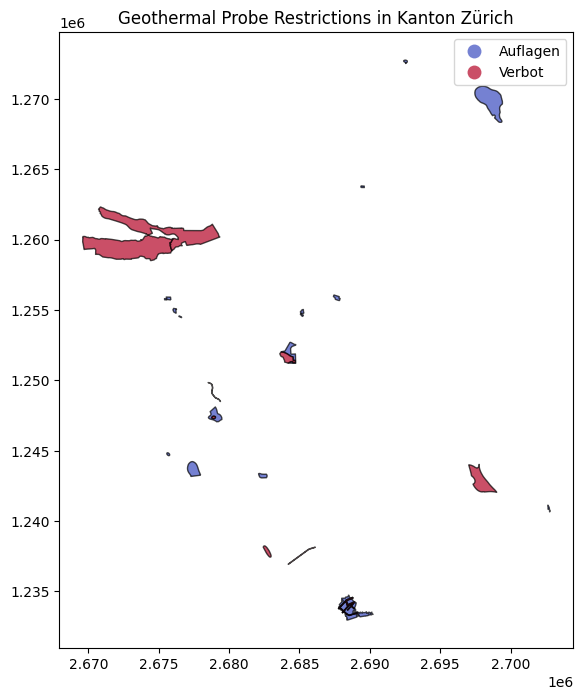

In [12]:
# Plot the restrictions dataset
fig, ax = plt.subplots(figsize=(10, 8))
zh_restrictions_gdf.plot(ax=ax, column="zonen", cmap="coolwarm", legend=True, edgecolor="black", alpha=0.7)

# Add title
ax.set_title("Geothermal Probe Restrictions in Kanton Zürich")

# Show plot
plt.show()

---

### Interactive Plots

In [13]:
# Create a copy of the dataset to avoid modifying the original
restrictions_gdf_copy = zh_restrictions_gdf.copy()

# Convert the copied dataset to WGS84
restrictions_gdf_copy = restrictions_gdf_copy.to_crs(epsg=4326)

# Create a new column with GeoJSON-style geometry
restrictions_gdf_copy["geometry_str"] = restrictions_gdf_copy["geometry"].apply(lambda geom: geom.__geo_interface__)

# Create the Plotly map
fig = px.choropleth_mapbox(
    restrictions_gdf_copy,
    geojson=restrictions_gdf_copy.__geo_interface__,  # Use full GeoDataFrame as GeoJSON
    locations=restrictions_gdf_copy.index,
    color="zonen",
    color_discrete_map={"Auflagen": "blue", "Verbot": "red"},
    hover_name="zonen",
    title="Geothermal Restrictions in Kanton Zürich",
    mapbox_style="carto-positron",
    zoom=9,
    height=800
)

fig.update_layout(
    mapbox_center={"lat": restrictions_gdf_copy.geometry.centroid.y.mean(),
                   "lon": restrictions_gdf_copy.geometry.centroid.x.mean()},
    mapbox_zoom=10  # Adjust based on region
)

# Show the map
fig.show()

C:\Users\leina\AppData\Local\Temp\ipykernel_15784\1694786910.py:25: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\leina\AppData\Local\Temp\ipykernel_15784\1694786910.py:26: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


